# Introduction

Background:

Our company develops innovative Artificial Intelligence and Computer Vision solutions that revolutionize industries. Machines that can see: We pack our solutions in small yet intelligent devices that can be easily integrated to your existing data flow. Computer vision for everyone: Our devices can recognize faces, estimate age and gender, classify clothing types and colors, identify everyday objects and detect motion. Technical consultancy: We help you identify use cases of artificial intelligence and computer vision in your industry. Artificial intelligence is the technology of today, not the future.

MonReader is a new mobile document digitization experience for the blind, for researchers and for everyone else in need for fully automatic, highly fast and high-quality document scanning in bulk. It is composed of a mobile app and all the user needs to do is flip pages and everything is handled by MonReader: it detects page flips from low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor.

![title](https://go.apziva.com/static/img/project_10_1.png)


![title](https://go.apziva.com/static/img/project_10_2.jpg)

### Goal(s):

Predict if the page is being flipped using a single image.


Bonus(es):

Predict if a given sequence of images contains an action of flipping.
Submission Instructions:
Project should be implemented with Python
Please name your repository on GitHub with this name without exposing your project information: SXwrsbaVlFLhu5N2

# Imports

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import random
import os

import tensorflow as tf
from skimage.io import imread
from skimage.transform import resize, rotate, AffineTransform, warp
from tensorflow.keras import models
from keras.models import Sequential, Model
from tensorflow.keras import layers
from keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization, ReLU, Activation
from tensorflow.keras.initializers import he_uniform
from tensorflow.keras import optimizers
from tensorflow.keras.applications import *
from keras.callbacks import EarlyStopping



from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

## Data Visualisation


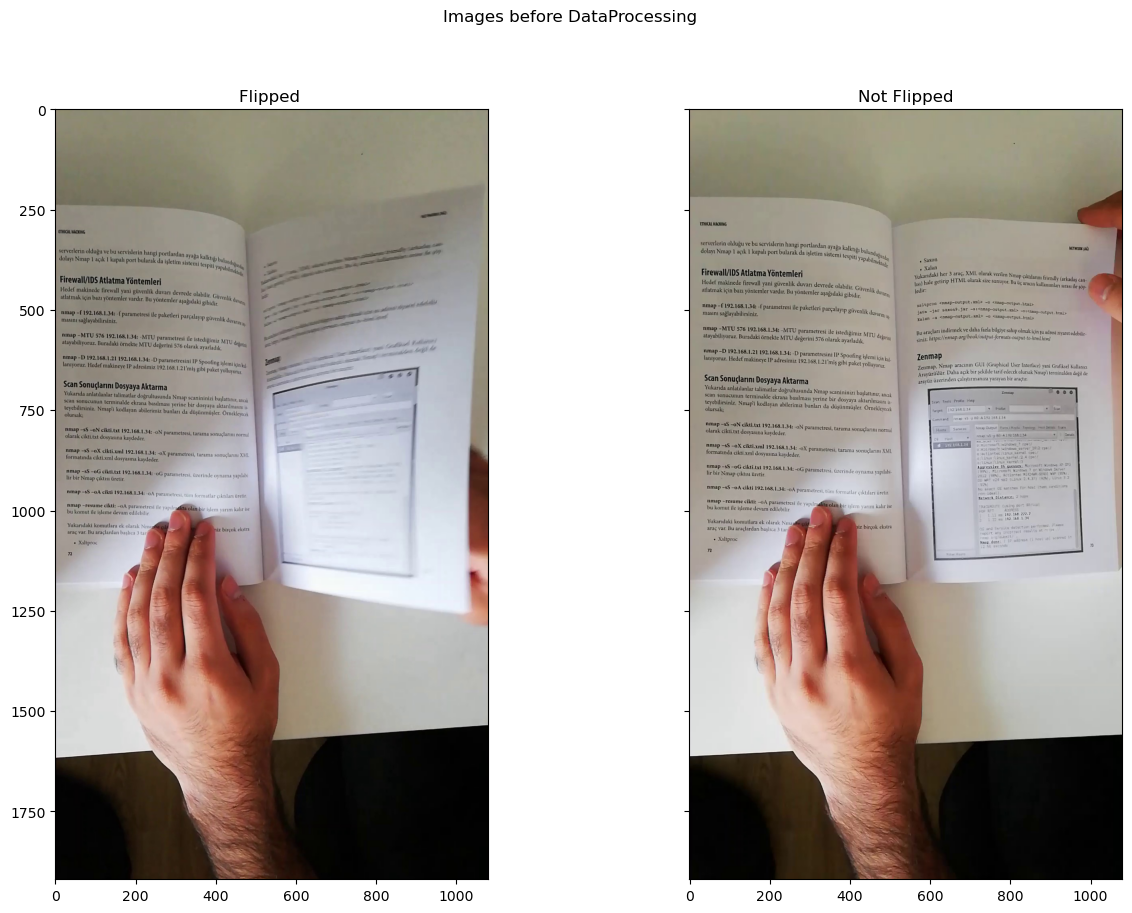

In [99]:
data_flip = plt.imread(r'C:\Users\ibane\OneDrive\Python\Apziva\Apziva - Project 4\images (1)\images\training\flip\0001_000000010.jpg')
data_notflip = plt.imread(r"C:\Users\ibane\OneDrive\Python\Apziva\Apziva - Project 4\images (1)\images\training\notflip\0001_000000003.jpg")
fig, ax = plt.subplot_mosaic([['flip', 'notflip']], sharey = True, sharex = True, figsize=(15, 10))
ax['flip'].imshow(data_flip)
im = ax['notflip'].imshow(data_notflip)
ax['flip'].set_title('Flipped ')
ax['notflip'].set_title('Not Flipped')
plt.suptitle('Images before DataProcessing')
plt.show()

In [100]:
print(data_flip.shape)

(1920, 1080, 3)


In [101]:
print(data_notflip.shape)

(1920, 1080, 3)


# Data Description

We collected page flipping video from smart phones and labelled them as flipping and not flipping.

We clipped the videos as short videos and labelled them as flipping or not flipping. The extracted frames are then saved to disk in a sequential order with the following naming structure: VideoID_FrameNumber

1. Dataset is quite small: let's increase the number of number of datasets by rotating and flipping the images so we have an increased dataset. 
2. As expected, the dataset is labelled so we need to split the testing set into labels and images. This will help us judge the predictions from the model with the actual labels. 

- resize 
- shuffle




### Paths of training and testing datasets

In [102]:
path_training_set = r"C:\Users\ibane\OneDrive\Python\Apziva\Apziva - Project 4\images (1)\images\training"
path_test_set = r"C:\Users\ibane\OneDrive\Python\Apziva\Apziva - Project 4\images (1)\images\testing"

In [103]:
train_dataset = tf.keras.utils.image_dataset_from_directory(path_training_set,
                                                            shuffle=True,
                                                            batch_size=32,
                                                            validation_split=0.2,
                                                            subset='training',
                                                            seed=27,
                                                            image_size=(320, 180))

validation_dataset = tf.keras.utils.image_dataset_from_directory(path_training_set,
                                                                 shuffle=True,
                                                                 batch_size=32,
                                                                 validation_split=0.2,
                                                                 subset='validation',
                                                                 seed=27,
                                                                 image_size=(320, 180))

test_dataset = tf.keras.utils.image_dataset_from_directory(path_test_set,
                                                           shuffle=True,
                                                           batch_size=597,
                                                           image_size=(320, 180)) 

Found 2392 files belonging to 2 classes.
Using 1914 files for training.
Found 2392 files belonging to 2 classes.
Using 478 files for validation.
Found 597 files belonging to 2 classes.


In [104]:
print(train_dataset.class_names)

['flip', 'notflip']


In [105]:
print(test_dataset.class_names)

['flip', 'notflip']


In [106]:
print(validation_dataset.class_names)

['flip', 'notflip']


In [107]:
train_dataset.cardinality().numpy()

60

In [108]:
validation_dataset.cardinality().numpy()

15

In [109]:
training_images, training_labels = next(iter(train_dataset))

In [110]:
validation_images, validation_labels = next(iter(validation_dataset))

In [111]:
test_images, test_labels = next(iter(test_dataset))

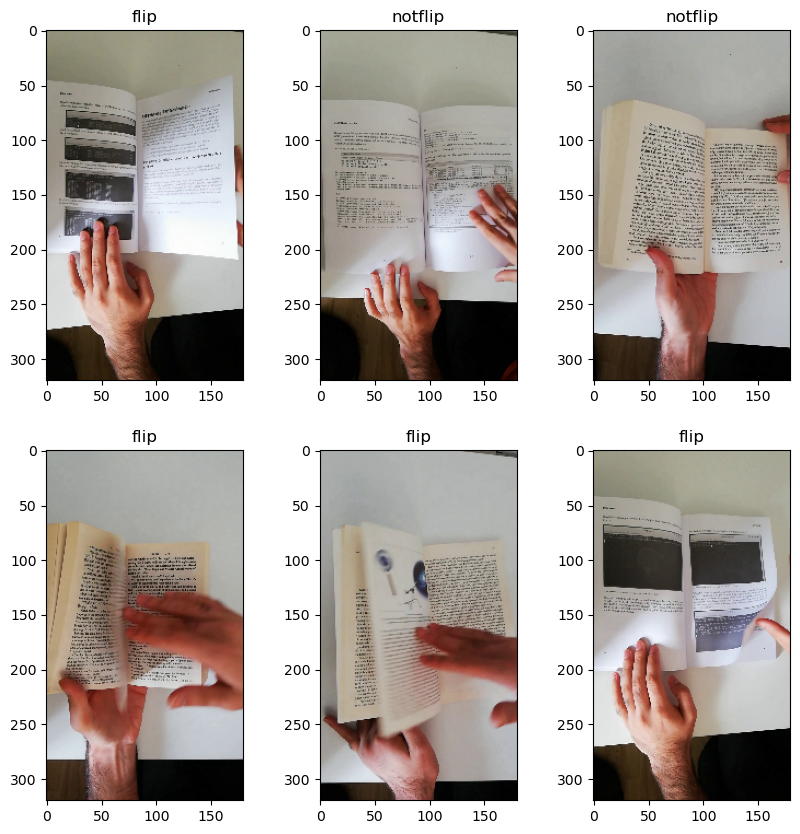

In [112]:
plt.figure(figsize=(10, 10))
class_names = train_dataset.class_names
for images, labels in train_dataset.take(1):
    for i in range(6):
        plt.subplot(2, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])

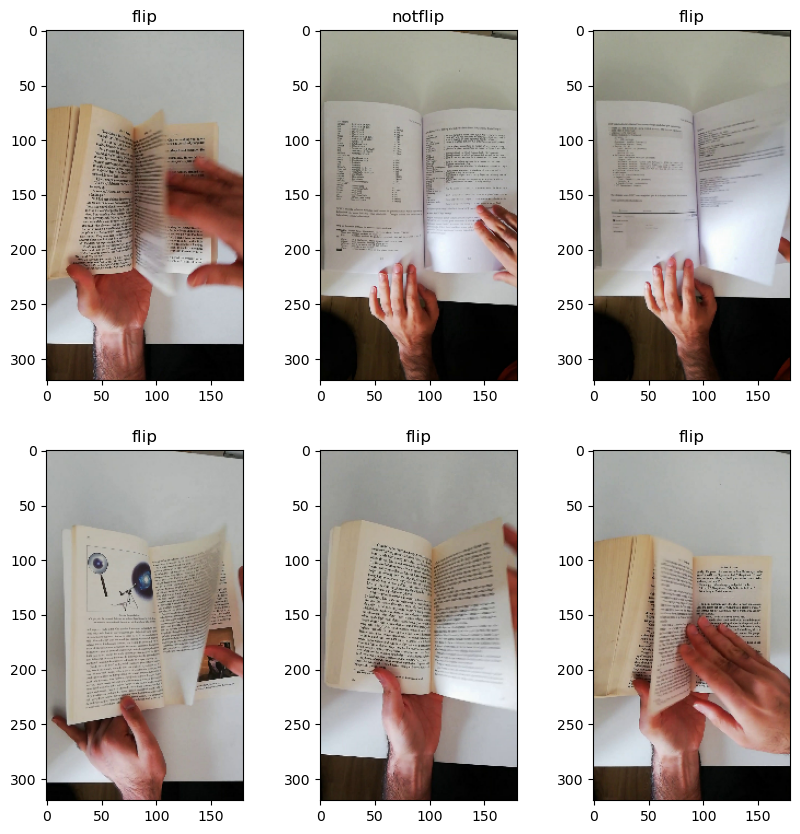

In [113]:
plt.figure(figsize=(10, 10))
class_names = test_dataset.class_names
for images, labels in test_dataset.take(1):
    for i in range(6):
        plt.subplot(2, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])

# Convolution Network

CNN Architecture

In [118]:
def CNN(input_size = (320, 180, 3)):
    inputs = Input(input_size)
    
    M = Conv2D(16, (7,7), strides = (2,2), kernel_initializer = he_uniform())(inputs)
    M = BatchNormalization(axis = 3)(M)
    M = Activation('relu')(M)
    M = MaxPooling2D((3, 3), strides=(2, 2))(M)
    
    M = Conv2D(64, (5, 5), strides = (2, 2), kernel_initializer = he_uniform())(M)
    M = BatchNormalization(axis = 3)(M)
    M = Activation('relu')(M)
    M = MaxPooling2D((2, 2), strides=(2, 2))(M)
    
    M = Conv2D(256, (3, 3), strides = (1, 1), kernel_initializer = he_uniform())(M)
    M = BatchNormalization(axis = 3)(M)
    M = Activation('relu')(M)
    M = MaxPooling2D((2, 2), strides=(2, 2))(M)
    
    M = Flatten()(M)
    M = Dense(256, activation='relu', kernel_initializer = he_uniform())(M)
    M = Dense(32, activation='relu', kernel_initializer = he_uniform())(M)
    outputs = Dense(1, activation='sigmoid', kernel_initializer = he_uniform())(M)
    
    model = Model(inputs = inputs, outputs = outputs)
    
    return model
    


In [119]:
import keras.backend as K

In [120]:

def f1_score(y_true, y_pred): 
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tp_fn = K.sum(K.round(K.clip(y_true, 0, 1)))
    tp_fp = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = tp / (tp_fp + K.epsilon())
    recall = tp / (tp_fn + K.epsilon())
    f1 = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1


In [121]:
#initialize model 
model = CNN((320, 180, 3))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score])

print(model.summary())
     

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 320, 180, 3)]     0         
                                                                 
 conv2d_36 (Conv2D)          (None, 157, 87, 16)       2368      
                                                                 
 batch_normalization_36 (Bat  (None, 157, 87, 16)      64        
 chNormalization)                                                
                                                                 
 activation_36 (Activation)  (None, 157, 87, 16)       0         
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 78, 43, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 37, 20, 64)        25664 

In [122]:
history = model.fit(train_dataset, epochs = 10)

Epoch 1/10
60/60 [==============================] - 66s 1s/step - loss: 0.8767 - accuracy: 0.7806 - f1_score: 0.7457
Epoch 2/10
60/60 [==============================] - 60s 959ms/step - loss: 0.1211 - accuracy: 0.9603 - f1_score: 0.9605
Epoch 3/10
60/60 [==============================] - 56s 891ms/step - loss: 0.0594 - accuracy: 0.9812 - f1_score: 0.9810
Epoch 4/10
60/60 [==============================] - 58s 934ms/step - loss: 0.0317 - accuracy: 0.9896 - f1_score: 0.9897
Epoch 5/10
60/60 [==============================] - 56s 889ms/step - loss: 0.0159 - accuracy: 0.9979 - f1_score: 0.9975
Epoch 6/10
60/60 [==============================] - 58s 926ms/step - loss: 0.0111 - accuracy: 0.9990 - f1_score: 0.9989
Epoch 7/10
60/60 [==============================] - 59s 939ms/step - loss: 0.0167 - accuracy: 0.9937 - f1_score: 0.9940
Epoch 8/10
60/60 [==============================] - 57s 909ms/step - loss: 0.0106 - accuracy: 0.9974 - f1_score: 0.9974
Epoch 9/10
60/60 [=========================

In [123]:
model.evaluate(test_dataset)

1/1 [==============================] - 5s 5s/step - loss: 0.0588 - accuracy: 0.9849 - f1_score: 0.9856


[0.05881746858358383, 0.9849246144294739, 0.9855537414550781]

# EfficientNet

In [32]:
enet = EfficientNetB0(weights="imagenet", input_shape=(320, 180, 3), include_top=False)
enet.trainable=False

In [33]:
inputs = tf.keras.Input(shape=(320, 180,3))
x = img_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = enet(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(1, activation='sigmoid', name='pred')(x)

enet_train = tf.keras.Model(inputs=inputs, outputs=output)
enet_train.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 320, 180, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 320, 180, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 10, 6, 1280)      4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0     

In [34]:
enet_train.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
                   loss='binary_crossentropy', 
                   metrics=['accuracy'])

In [35]:
early_stop = EarlyStopping(monitor='val_loss', mode = 'min', patience= 10, verbose = 1)

In [36]:
res = enet_train.fit(train_dataset, epochs=5, validation_data=validation_dataset, callbacks=[early_stop])

Epoch 1/5
60/60 [==============================] - 230s 3s/step - loss: 0.4468 - accuracy: 0.8009 - val_loss: 0.5679 - val_accuracy: 0.6611
Epoch 2/5
60/60 [==============================] - 253s 4s/step - loss: 0.2997 - accuracy: 0.8704 - val_loss: 0.3143 - val_accuracy: 0.8724
Epoch 3/5
60/60 [==============================] - 229s 4s/step - loss: 0.2282 - accuracy: 0.9075 - val_loss: 0.3649 - val_accuracy: 0.8096
Epoch 4/5
60/60 [==============================] - 229s 4s/step - loss: 0.2258 - accuracy: 0.9107 - val_loss: 0.2981 - val_accuracy: 0.8494
Epoch 5/5
60/60 [==============================] - 255s 4s/step - loss: 0.1938 - accuracy: 0.9279 - val_loss: 0.2089 - val_accuracy: 0.9100


In [37]:
test_images, test_labels = next(iter(test_dataset))
enet_train.evaluate(test_images, test_labels)

19/19 [==============================] - 60s 3s/step - loss: 0.2037 - accuracy: 0.9246


[0.20374034345149994, 0.9246231317520142]

In [38]:
predictions = enet_train.predict(test_images)

19/19 [==============================] - 75s 4s/step


# Success Metrics:

Evaluate model performance based on F1 score, the higher the better.


In [39]:
acc = accuracy_score(test_labels, np.round(predictions))
confusion_mtr = confusion_matrix(test_labels, np.round(predictions))
print(confusion_mtr)
tn, fp, fn, tp = confusion_mtr.ravel()
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print(f'Accuracy: {acc}%')
print(f'Precision: {precision}%')
print(f'Recall: {recall}%')
print(f'F1-score: {2*precision*recall/(precision+recall)}%')

[[246  44]
 [  1 306]]
Accuracy: 0.9246231155778895%
Precision: 87.42857142857143%
Recall: 99.6742671009772%
F1-score: 93.15068493150685%
